<a href="https://colab.research.google.com/github/Dhairyakumarshah/Medical_Image/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pandas opencv-python-headless scikit-learn

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [15]:
# Update this based on your dataset location in Drive
image_root = '/content/drive/MyDrive/UW GI classification/train'  # Folder containing all case folders
csv_path = '/content/drive/MyDrive/UW GI classification/train.csv'  # Path to train.csv


In [17]:
# Step 5: Load the CSV and generate image paths
df = pd.read_csv(csv_path)
df['segmentation'] = df.segmentation.fillna('')  # fill empty masks
df['rle_len'] = df.segmentation.map(len)  # optional: length of RLE
df['empty'] = (df.rle_len == 0)  # mark empty masks

In [18]:
# Extract case, day, and slice from `id`
def extract_parts(row):
    parts = row['id'].split('_')
    return pd.Series({
        'case': parts[0],
        'day': parts[1],
        'slice': int(parts[3])
    })

df = df.join(df.apply(extract_parts, axis=1))


In [19]:
# Construct image path
def build_image_path(row):
    return os.path.join(
        image_root,
        f"{row['case']}",
        f"{row['case']}_{row['day']}",
        "scans",
        f"slice_{row['slice']:04d}_266_266_1.50_1.50.png"
    )

df['image_path'] = df.apply(build_image_path, axis=1)


In [20]:
# Filter one image per ID for classification (can choose first by group)
df_class = df.groupby(['id', 'class']).first().reset_index()

In [26]:
import os

image_folder = "/content/drive/MyDrive/UW GI classification/train/case101/case101_day20/scans/"
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Print filenames to inspect
for image_file in image_files[:5]:  # Checking first 5 images
    print(f"Filename: {image_file}")


Filename: slice_0030_266_266_1.50_1.50.png
Filename: slice_0001_266_266_1.50_1.50.png
Filename: slice_0008_266_266_1.50_1.50.png
Filename: slice_0005_266_266_1.50_1.50.png
Filename: slice_0002_266_266_1.50_1.50.png


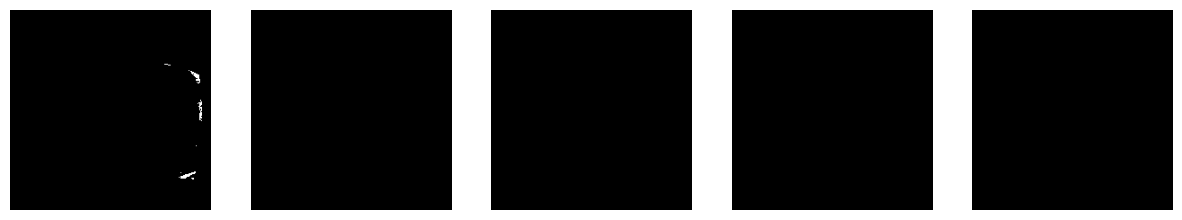

In [24]:
# Update the load_and_normalize function to handle grayscale images
def load_and_normalize_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if img is None:
        return None
    img = cv2.resize(img, (224, 224))  # Resize the image
    img = np.expand_dims(img, axis=-1)  # Add a channel dimension (e.g., for grayscale)
    img = img / 255.0  # Normalize the image
    return img

# Load and normalize a few sample images
sample_images = [load_and_normalize_image(image_paths[i]) for i in range(5)]

# Display the images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    if sample_images[i] is not None:
        ax.imshow(sample_images[i].squeeze(), cmap='gray')  # Display grayscale image
        ax.axis('off')
    else:
        ax.axis('off')
plt.show()


In [29]:
import re
import os

def extract_metadata_from_filename(filename):
    # Try a more flexible regex to handle the filename format
    match = re.match(r"slice_(\d+)_(\d+)_(\d+)_(\d+\.\d+)_(\d+\.\d+)\.png", filename)
    if match:
        slice_number = int(match.group(1))  # slice number
        width = int(match.group(2))         # image width in pixels
        height = int(match.group(3))        # image height in pixels
        pixel_spacing_width = float(match.group(4))  # pixel spacing (width) in mm
        pixel_spacing_height = float(match.group(5)) # pixel spacing (height) in mm

        return slice_number, width, height, pixel_spacing_width, pixel_spacing_height
    else:
        print(f"Regex match failed for filename: {filename}")
        return None

# Folder path where images are stored
image_folder = "/content/drive/MyDrive/UW GI classification/train/case101/case101_day20/scans/"
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Extract metadata for the first 5 images
for image_file in image_files[:5]:  # Checking first 5 images
    metadata = extract_metadata_from_filename(image_file)
    if metadata:
        print(f"File: {image_file} -> Slice: {metadata[0]}, Resolution: {metadata[1]}x{metadata[2]}, Pixel Spacing: {metadata[3]}x{metadata[4]} mm")
    else:
        print(f"Could not extract metadata for file: {image_file}")


File: slice_0030_266_266_1.50_1.50.png -> Slice: 30, Resolution: 266x266, Pixel Spacing: 1.5x1.5 mm
File: slice_0001_266_266_1.50_1.50.png -> Slice: 1, Resolution: 266x266, Pixel Spacing: 1.5x1.5 mm
File: slice_0008_266_266_1.50_1.50.png -> Slice: 8, Resolution: 266x266, Pixel Spacing: 1.5x1.5 mm
File: slice_0005_266_266_1.50_1.50.png -> Slice: 5, Resolution: 266x266, Pixel Spacing: 1.5x1.5 mm
File: slice_0002_266_266_1.50_1.50.png -> Slice: 2, Resolution: 266x266, Pixel Spacing: 1.5x1.5 mm


In [30]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Step 1: Define the function to extract metadata from filenames
def extract_metadata_from_filename(filename):
    import re
    pattern = r'slice_(\d+)_\d+_\d+_(\d+\.\d+)_'
    match = re.match(pattern, filename)
    if match:
        slice_number = int(match.group(1))
        pixel_spacing = float(match.group(2))
        return slice_number, pixel_spacing
    return None, None

# Step 2: Load CSV and image paths
train_csv_path = '/content/drive/MyDrive/UW GI classification/train.csv'
df = pd.read_csv(train_csv_path)

# Ensure segmentation is filled (adjust if needed)
df['segmentation'] = df.segmentation.fillna('')

# Step 3: Prepare image paths
image_dir = "/content/drive/MyDrive/UW GI classification/train"
image_paths = []

# Loop to get image paths from the directory
for case_folder in os.listdir(image_dir):
    case_path = os.path.join(image_dir, case_folder)
    if os.path.isdir(case_path):
        for day_folder in os.listdir(case_path):
            day_path = os.path.join(case_path, day_folder, 'scans')
            if os.path.isdir(day_path):
                for img_file in os.listdir(day_path):
                    img_path = os.path.join(day_path, img_file)
                    if img_path.endswith('.png'):
                        image_paths.append(img_path)

# Step 4: Load and preprocess images
images = []
labels = []  # You'll need to create labels from your data, this is just an example
for img_path in image_paths:
    # Extract metadata
    slice_number, pixel_spacing = extract_metadata_from_filename(img_path)

    if slice_number is not None:
        # Load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize to ResNet50 input size
        img = img / 255.0  # Normalize image
        images.append(img)

        # Create dummy label (Replace with actual labels from your CSV)
        labels.append(slice_number)  # Replace this with the actual class if available

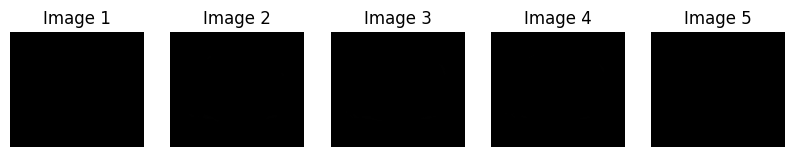

In [31]:
import matplotlib.pyplot as plt
import cv2

# Function to show a sample of images
def display_sample_images(image_paths, num_images=5):
    plt.figure(figsize=(10, 10))

    # Select a few images to display
    for i, img_path in enumerate(image_paths[:num_images]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

    plt.show()

# Call the function to display images
display_sample_images(image_paths, num_images=5)  # Adjust num_images to display more/less


In [32]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Function to normalize and show images
def normalize_and_display_images(image_paths, num_images=5):
    plt.figure(figsize=(10, 10))

    # Select a few images to display
    for i, img_path in enumerate(image_paths[:num_images]):
        img = cv2.imread(img_path)

        # Normalize the image (scale pixel values to 0-1)
        img_normalized = img / 255.0

        # Convert to RGB (since OpenCV loads images in BGR)
        img_normalized_rgb = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_normalized_rgb)
        plt.title(f"Normalized Image {i + 1}")
        plt.axis('off')

    plt.show()

# Call the function to display normalized images
normalize_and_display_images(image_paths, num_images=5)  # Adjust num_images to display more/less


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


<Figure size 1000x1000 with 0 Axes>